In [10]:
datasetdir = 'C:\\Users\\reekithak\\Audio_Models\\Data\\Images'
import os
os.chdir(datasetdir)

import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        #horizontal_flip = True, 
        validation_split = 0.25,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('bad','good'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('bad','good'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [12]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [13]:
resnet50 = keras.applications.resnet50
train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 1662 images belonging to 2 classes.
Found 554 images belonging to 2 classes.


In [14]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [15]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE = 3
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'C:\\Users\\reekithak\\Audio_Models\\5.resnet\\new_res50.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [16]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=15,
    callbacks=[cb_checkpointer, cb_early_stopper]
)
full_model.load_weights('C:\\Users\\reekithak\\Audio_Models\\5.resnet\\new_res50.hdf5')

Epoch 1/15
52/52 [==============================] - 183s 3s/step - loss: 2.4013 - acc: 0.7310 - val_loss: 0.2543 - val_acc: 0.9224
Epoch 2/15
52/52 [==============================] - 178s 3s/step - loss: 0.0520 - acc: 0.9775 - val_loss: 0.2311 - val_acc: 0.9314
Epoch 3/15
52/52 [==============================] - 177s 3s/step - loss: 0.0082 - acc: 0.9976 - val_loss: 0.1654 - val_acc: 0.9477
Epoch 4/15
52/52 [==============================] - 177s 3s/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.1772 - val_acc: 0.9368
Epoch 5/15
52/52 [==============================] - 177s 3s/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.2061 - val_acc: 0.9386
Epoch 6/15
52/52 [==============================] - 176s 3s/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.1839 - val_acc: 0.9386


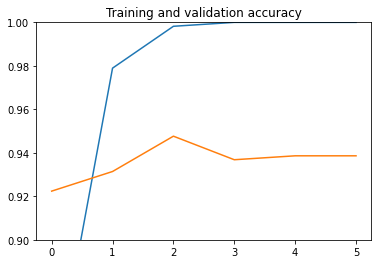

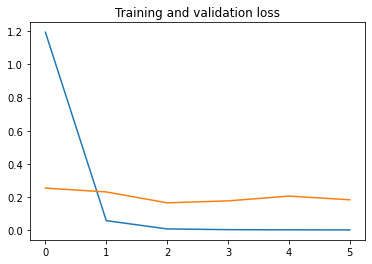

In [17]:
plot_history(history, yrange=(0.9,1))

In [18]:
full_model.save('new_res50.h5')